In [1]:
import numpy as np
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
%matplotlib inline

from osgeo import gdal, ogr, osr
from shapely.geometry import Polygon, box
import imageio

# Split Africa datasets into train, val, test

## Senegal

In [7]:
senegal_tiles = pd.read_csv('../data/planet/senegal/bbox_tiles_overlap.csv')
senegal_tiles['image_id'] = senegal_tiles['image_id'].astype(str).str.zfill(5)

In [8]:
senegal_tiles.head()

,image_id,min_lon,min_lat,max_lon,max_lat
0,00060,-16.336502,14.252279,-16.324936,14.263559
1,00141,-16.325178,14.252342,-16.313613,14.263622
2,00142,-16.325243,14.263386,-16.313677,14.274666
3,00221,-16.313791,14.241360,-16.302227,14.252640
4,00222,-16.313855,14.252404,-16.302290,14.263684


In [27]:
df = senegal_tiles.copy()

tile_ids = df['image_id'].values
sampled = []
folds = []
tiles_to_check = set()

for i, row in df.iterrows():
    tile_id = row['image_id']
    
    if tile_id not in sampled:
        print("Sampling a new tile, tile", tile_id)
        
        # if tile hasn't been sampled already,
        # assign it to a fold
        fold = np.random.choice(['train', 'val', 'test'], p=[0.6, 0.2, 0.2])
        sampled.append(tile_id)
        folds.append(fold)
        
        min_lon, min_lat = row['min_lon'], row['min_lat']
        max_lon, max_lat = row['max_lon'], row['max_lat']
        tiles_to_check.add((tile_id, min_lon, min_lat, max_lon, max_lat))
        
        while tiles_to_check != set():
            tile_id, min_lon, min_lat, max_lon, max_lat = tiles_to_check.pop()
            tile_poly = box(min_lon, min_lat, max_lon, max_lat)
            possibly_overlapping_tiles = df[(df['max_lon'] >= min_lon) &
                                            (df['min_lon'] <= max_lon) &
                                            (df['max_lat'] >= min_lat) & 
                                            (df['min_lat'] <= max_lat)].reset_index(drop=True)

            for j, row2 in possibly_overlapping_tiles.iterrows():
                tile_id2 = row2['image_id']
                
                if tile_id2 not in sampled:
                    print("    Tile {} is connected".format(tile_id2))
                    min_lon2, min_lat2 = row2['min_lon'], row2['min_lat']
                    max_lon2, max_lat2 = row2['max_lon'], row2['max_lat']
                    tile_poly2 = box(min_lon2, min_lat2, max_lon2, max_lat2)

                    if tile_poly.intersects(tile_poly2):
                        # assign all touching tiles to the same fold
                        sampled.append(tile_id2)
                        folds.append(fold)
                        tiles_to_check.add((tile_id2, min_lon2, min_lat2, max_lon2, max_lat2))
            

Sampling a new tile, tile 00060
    Tile 00141 is connected
    Tile 00142 is connected
    Tile 00222 is connected
    Tile 00223 is connected
    Tile 00224 is connected
    Tile 00221 is connected
    Tile 00302 is connected
    Tile 00303 is connected
    Tile 00304 is connected
    Tile 00383 is connected
    Tile 00384 is connected
    Tile 00225 is connected
    Tile 00385 is connected
    Tile 00386 is connected
Sampling a new tile, tile 00297
    Tile 00298 is connected
    Tile 00378 is connected
    Tile 00379 is connected
    Tile 00380 is connected
    Tile 00461 is connected
    Tile 00381 is connected
    Tile 00462 is connected
    Tile 00300 is connected
Sampling a new tile, tile 01009
    Tile 01010 is connected
    Tile 01090 is connected
    Tile 01091 is connected
    Tile 01011 is connected
    Tile 01092 is connected
    Tile 01173 is connected
    Tile 01093 is connected
    Tile 01174 is connected
Sampling a new tile, tile 01223
    Tile 01303 is connected
    

Sampling a new tile, tile 04779
    Tile 04860 is connected
    Tile 04861 is connected
    Tile 04941 is connected
Sampling a new tile, tile 05137
    Tile 05217 is connected
    Tile 05218 is connected
    Tile 05298 is connected
    Tile 05299 is connected
    Tile 05379 is connected
    Tile 05380 is connected
Sampling a new tile, tile 05144
    Tile 05224 is connected
    Tile 05225 is connected
    Tile 05226 is connected
    Tile 05223 is connected
    Tile 05304 is connected
    Tile 05305 is connected
    Tile 05306 is connected
    Tile 05387 is connected
    Tile 05227 is connected
    Tile 05307 is connected
    Tile 05308 is connected
    Tile 05388 is connected
    Tile 05228 is connected
    Tile 05309 is connected
Sampling a new tile, tile 05189
    Tile 05190 is connected
    Tile 05271 is connected
    Tile 05191 is connected
Sampling a new tile, tile 05284
    Tile 05285 is connected
    Tile 05365 is connected
    Tile 05366 is connected
    Tile 05446 is connected


    Tile 13940 is connected
    Tile 13690 is connected
    Tile 14022 is connected
Sampling a new tile, tile 13678
    Tile 13760 is connected
    Tile 13761 is connected
    Tile 13843 is connected
    Tile 13844 is connected
    Tile 13845 is connected
    Tile 13927 is connected
Sampling a new tile, tile 13860
Sampling a new tile, tile 14207
    Tile 14288 is connected
    Tile 14289 is connected
    Tile 14372 is connected
    Tile 14373 is connected
    Tile 14454 is connected
    Tile 14455 is connected
    Tile 14537 is connected
    Tile 14535 is connected
    Tile 14534 is connected


In [28]:
split_df = pd.DataFrame({
    'image_id': sampled,
    'fold': folds
})

In [33]:
split_df.groupby('fold').size() / split_df.shape[0]

fold
test     0.166392
train    0.634267
val      0.199341
dtype: float64

In [30]:
merged_split_df = senegal_tiles.merge(split_df, on='image_id', how='left')

In [32]:
merged_split_df.to_csv('../data/splits/senegal_planetImagery_splits_tiles_overlap.csv',
                       index=False)

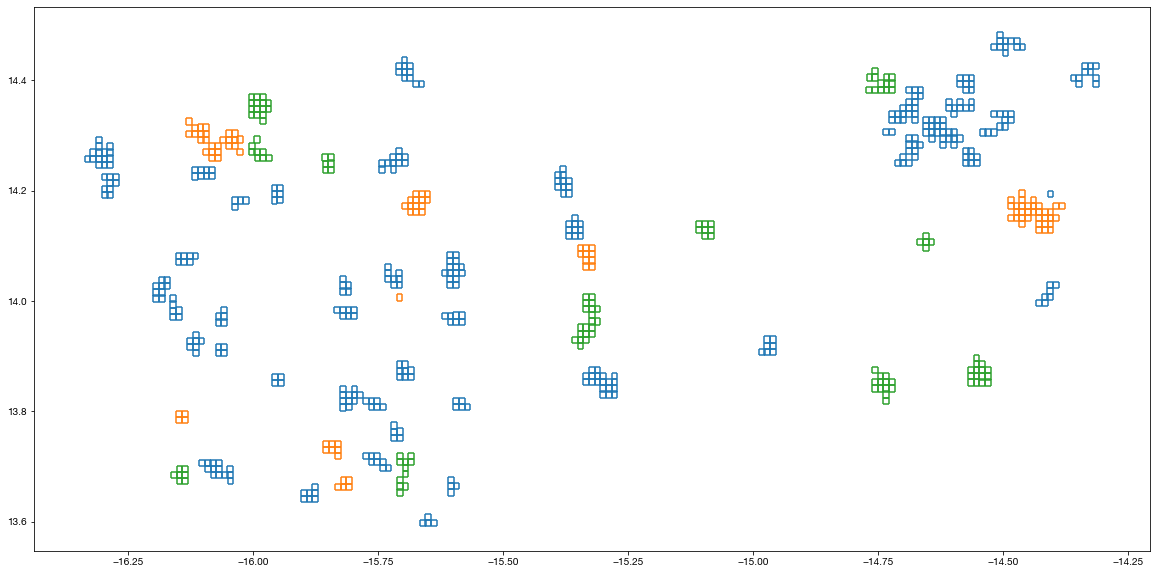

In [31]:
fig, ax = plt.subplots(1, figsize=(20,10), sharex=True, sharey=True)

for i, row in merged_split_df.iterrows():
    if row['fold'] == 'train':
        c = 'C0'
    elif row['fold'] == 'val':
        c = 'C2'
    elif row['fold'] == 'test':
        c = 'C1'
    ax.vlines(row['min_lon'], row['min_lat'], row['max_lat'], color=c)
    ax.vlines(row['max_lon'], row['min_lat'], row['max_lat'], color=c)
    ax.hlines(row['min_lat'], row['min_lon'], row['max_lon'], color=c)
    ax.hlines(row['max_lat'], row['min_lon'], row['max_lon'], color=c)
plt.show()

## Malawi

In [3]:
tiles = pd.read_csv('../data/planet/malawi/bbox_tiles_overlap.csv')
tiles['image_id'] = tiles['image_id'].astype(str).str.zfill(5)

In [28]:
df = tiles.copy()

tile_ids = df['image_id'].values
sampled = []
folds = []
tiles_to_check = set()

for i, row in df.iterrows():
    tile_id = row['image_id']
    
    if tile_id not in sampled:
        print("Sampling a new tile, tile", tile_id)
        
        # if tile hasn't been sampled already,
        # assign it to a fold
        fold = np.random.choice(['train', 'val', 'test'], p=[0.6, 0.2, 0.2])
        sampled.append(tile_id)
        folds.append(fold)
        
        min_lon, min_lat = row['min_lon'], row['min_lat']
        max_lon, max_lat = row['max_lon'], row['max_lat']
        tiles_to_check.add((tile_id, min_lon, min_lat, max_lon, max_lat))
        
        while tiles_to_check != set():
            tile_id, min_lon, min_lat, max_lon, max_lat = tiles_to_check.pop()
            tile_poly = box(min_lon, min_lat, max_lon, max_lat)
            possibly_overlapping_tiles = df[(df['max_lon'] >= min_lon) &
                                            (df['min_lon'] <= max_lon) &
                                            (df['max_lat'] >= min_lat) & 
                                            (df['min_lat'] <= max_lat)].reset_index(drop=True)

            for j, row2 in possibly_overlapping_tiles.iterrows():
                tile_id2 = row2['image_id']
                
                if tile_id2 not in sampled:
                    print("    Tile {} is connected".format(tile_id2))
                    min_lon2, min_lat2 = row2['min_lon'], row2['min_lat']
                    max_lon2, max_lat2 = row2['max_lon'], row2['max_lat']
                    tile_poly2 = box(min_lon2, min_lat2, max_lon2, max_lat2)

                    if tile_poly.intersects(tile_poly2):
                        # assign all touching tiles to the same fold
                        sampled.append(tile_id2)
                        folds.append(fold)
                        tiles_to_check.add((tile_id2, min_lon2, min_lat2, max_lon2, max_lat2))
            

Sampling a new tile, tile 00023
    Tile 00085 is connected
    Tile 00086 is connected
Sampling a new tile, tile 00061
Sampling a new tile, tile 00076
    Tile 00138 is connected
Sampling a new tile, tile 00092
    Tile 00154 is connected
Sampling a new tile, tile 00166
    Tile 00228 is connected
Sampling a new tile, tile 00175
    Tile 00236 is connected
    Tile 00237 is connected
Sampling a new tile, tile 00256
    Tile 00318 is connected
Sampling a new tile, tile 00284
    Tile 00346 is connected
Sampling a new tile, tile 00311
Sampling a new tile, tile 00425
    Tile 00426 is connected
    Tile 00487 is connected
Sampling a new tile, tile 00462
Sampling a new tile, tile 00539
Sampling a new tile, tile 00574
    Tile 00575 is connected
    Tile 00576 is connected
Sampling a new tile, tile 00584
    Tile 00646 is connected
Sampling a new tile, tile 00592
    Tile 00654 is connected
Sampling a new tile, tile 00641
    Tile 00642 is connected
    Tile 00704 is connected
Sampling a n

In [29]:
split_df = pd.DataFrame({
    'image_id': sampled,
    'fold': folds
})
merged_split_df = tiles.merge(split_df, on='image_id', how='left')
split_df.groupby('fold').size() / split_df.shape[0]

fold
test     0.224719
train    0.584270
val      0.191011
dtype: float64

In [31]:
merged_split_df.to_csv('../data/splits/malawi_planetImagery_splits_tiles_overlap.csv',
                       index=False)

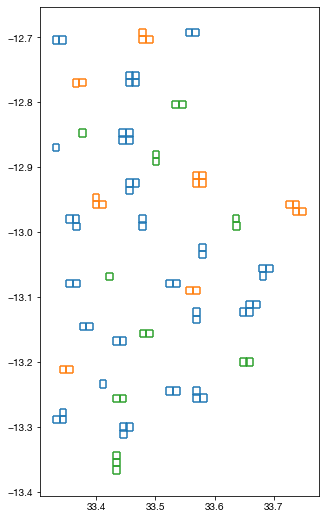

In [30]:
fig, ax = plt.subplots(1, figsize=(5,9), sharex=True, sharey=True)

for i, row in merged_split_df.iterrows():
    if row['fold'] == 'train':
        c = 'C0'
    elif row['fold'] == 'val':
        c = 'C2'
    elif row['fold'] == 'test':
        c = 'C1'
    ax.vlines(row['min_lon'], row['min_lat'], row['max_lat'], color=c)
    ax.vlines(row['max_lon'], row['min_lat'], row['max_lat'], color=c)
    ax.hlines(row['min_lat'], row['min_lon'], row['max_lon'], color=c)
    ax.hlines(row['max_lat'], row['min_lon'], row['max_lon'], color=c)
plt.show()

## Ghana Udry

In [32]:
tiles = pd.read_csv('../data/planet/ghana/udry/bbox_tiles_overlap.csv')
tiles['image_id'] = tiles['image_id'].astype(str).str.zfill(5)

In [35]:
df = tiles.copy()

tile_ids = df['image_id'].values
sampled = []
folds = []
tiles_to_check = set()

for i, row in df.iterrows():
    tile_id = row['image_id']
    
    if tile_id not in sampled:
        print("Sampling a new tile, tile", tile_id)
        
        # if tile hasn't been sampled already,
        # assign it to a fold
        fold = np.random.choice(['train', 'val', 'test'], p=[0.6, 0.2, 0.2])
        sampled.append(tile_id)
        folds.append(fold)
        
        min_lon, min_lat = row['min_lon'], row['min_lat']
        max_lon, max_lat = row['max_lon'], row['max_lat']
        tiles_to_check.add((tile_id, min_lon, min_lat, max_lon, max_lat))
        
        while tiles_to_check != set():
            tile_id, min_lon, min_lat, max_lon, max_lat = tiles_to_check.pop()
            tile_poly = box(min_lon, min_lat, max_lon, max_lat)
            possibly_overlapping_tiles = df[(df['max_lon'] >= min_lon) &
                                            (df['min_lon'] <= max_lon) &
                                            (df['max_lat'] >= min_lat) & 
                                            (df['min_lat'] <= max_lat)].reset_index(drop=True)

            for j, row2 in possibly_overlapping_tiles.iterrows():
                tile_id2 = row2['image_id']
                
                if tile_id2 not in sampled:
#                     print("    Tile {} is connected".format(tile_id2))
                    min_lon2, min_lat2 = row2['min_lon'], row2['min_lat']
                    max_lon2, max_lat2 = row2['max_lon'], row2['max_lat']
                    tile_poly2 = box(min_lon2, min_lat2, max_lon2, max_lat2)

                    if tile_poly.intersects(tile_poly2):
                        # assign all touching tiles to the same fold
                        sampled.append(tile_id2)
                        folds.append(fold)
                        tiles_to_check.add((tile_id2, min_lon2, min_lat2, max_lon2, max_lat2))
            

Sampling a new tile, tile 00059
Sampling a new tile, tile 00272
Sampling a new tile, tile 01135
Sampling a new tile, tile 01237
Sampling a new tile, tile 01995
Sampling a new tile, tile 01997
Sampling a new tile, tile 02139
Sampling a new tile, tile 02423
Sampling a new tile, tile 02684
Sampling a new tile, tile 02687
Sampling a new tile, tile 02691
Sampling a new tile, tile 02752
Sampling a new tile, tile 03235
Sampling a new tile, tile 03317
Sampling a new tile, tile 03550
Sampling a new tile, tile 03569
Sampling a new tile, tile 04223
Sampling a new tile, tile 04228
Sampling a new tile, tile 04345
Sampling a new tile, tile 04441
Sampling a new tile, tile 04476
Sampling a new tile, tile 04590
Sampling a new tile, tile 04778
Sampling a new tile, tile 05116
Sampling a new tile, tile 05121
Sampling a new tile, tile 05310
Sampling a new tile, tile 05424
Sampling a new tile, tile 05428
Sampling a new tile, tile 05520
Sampling a new tile, tile 05782
Sampling a new tile, tile 06203
Sampling

In [36]:
split_df = pd.DataFrame({
    'image_id': sampled,
    'fold': folds
})
merged_split_df = tiles.merge(split_df, on='image_id', how='left')
split_df.groupby('fold').size() / split_df.shape[0]

fold
test     0.255976
train    0.598606
val      0.145418
dtype: float64

In [41]:
merged_split_df.to_csv('../data/splits/ghana-udry_planetImagery_splits_tiles_overlap.csv',
                       index=False)

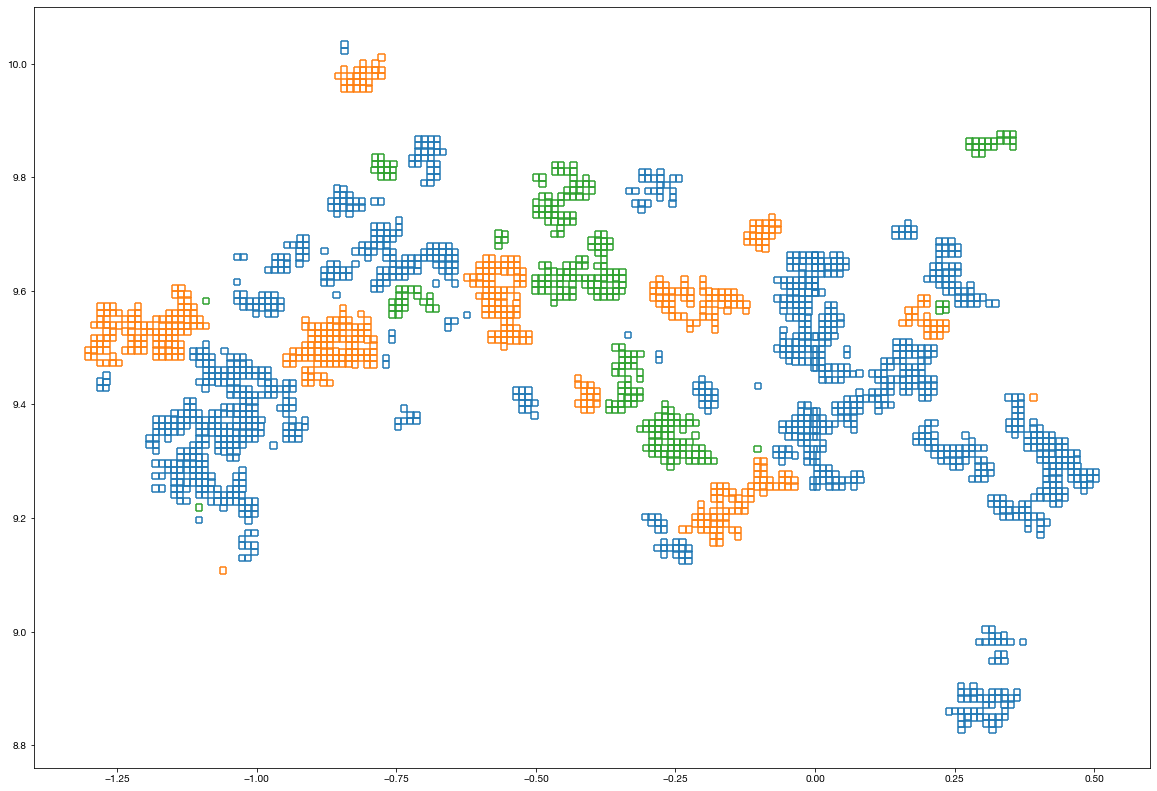

In [40]:
fig, ax = plt.subplots(1, figsize=(20,14), sharex=True, sharey=True)

for i, row in merged_split_df.iterrows():
    if row['fold'] == 'train':
        c = 'C0'
    elif row['fold'] == 'val':
        c = 'C2'
    elif row['fold'] == 'test':
        c = 'C1'
    ax.vlines(row['min_lon'], row['min_lat'], row['max_lat'], color=c)
    ax.vlines(row['max_lon'], row['min_lat'], row['max_lat'], color=c)
    ax.hlines(row['min_lat'], row['min_lon'], row['max_lon'], color=c)
    ax.hlines(row['max_lat'], row['min_lon'], row['max_lon'], color=c)
plt.show()